In [1]:
from transformers import (
    AutoTokenizer,
    TFAutoModelForQuestionAnswering,
    DefaultDataCollator,
    keras_callbacks,
)
import tensorflow as tf
from huggingface_hub import notebook_login
from question_answering.constants import constants
from question_answering.utils import core_qa_utils, extractive_qa_utils
from question_answering.paths import extractive_qa_paths

In [2]:
df_train, df_val, df_test = core_qa_utils.load_train_val_test_datasets(
    extractive_qa_paths.squad_dataset_dir
)

train_dataset, val_dataset, test_dataset = core_qa_utils.convert_dataframes_to_datasets(
    [df_train, df_val, df_test]
)

In [3]:
model_checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [4]:
def tokenize_sample(sample, max_tokens=None, padding=False):
    question = sample["question"].strip()
    context = sample["context"].strip()

    return tokenizer(question, context, max_length=max_tokens, padding=padding)


tokenized_train_dataset = train_dataset.map(tokenize_sample)
tokenized_val_dataset = val_dataset.map(tokenize_sample)
tokenized_test_dataset = test_dataset.map(tokenize_sample)

print(
    "Max number of tokens in tokenized train dataset: ",
    len(max(tokenized_train_dataset["input_ids"], key=len)),
)
print(
    "Max number of tokens in tokenized val dataset: ",
    len(max(tokenized_val_dataset["input_ids"], key=len)),
)
print(
    "Max number of tokens in tokenized test dataset: ",
    len(max(tokenized_test_dataset["input_ids"], key=len)),
)

Map:   0%|          | 0/68716 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (520 > 512). Running this sequence through the model will result in indexing errors


Map:   0%|          | 0/14724 [00:00<?, ? examples/s]

Map:   0%|          | 0/14725 [00:00<?, ? examples/s]

Max number of tokens in tokenized train dataset:  870
Max number of tokens in tokenized val dataset:  866
Max number of tokens in tokenized test dataset:  817


In [5]:
max_length = 384


def filter_samples_below_number_of_tokens(dataset, max_tokens: int):
    indices_to_remove = []

    # Find indices of samples where number of tokens exceeds max number of tokens
    for index, sample in enumerate(dataset):
        tokenized_sample = tokenize_sample(sample)
        if len(tokenized_sample["input_ids"]) > max_tokens:
            indices_to_remove.append(index)

    # Keep only samples with number of tokens less or equal than max number of tokens
    dataset_indices = range(len(dataset))
    filtered_dataset = dataset.select(
        index for index in dataset_indices if index not in set(indices_to_remove)
    )

    return filtered_dataset


filtered_train_dataset = filter_samples_below_number_of_tokens(
    train_dataset, max_tokens=max_length
)
filtered_val_dataset = filter_samples_below_number_of_tokens(
    val_dataset, max_tokens=max_length
)
filtered_test_dataset = filter_samples_below_number_of_tokens(
    test_dataset, max_tokens=max_length
)

Parameter 'indices'=<generator object filter_samples_below_number_of_tokens.<locals>.<genexpr> at 0x0000023C5CB32EA0> of the transform datasets.arrow_dataset.Dataset.select couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


In [6]:
print(
    "Number of samples in tokenized train dataset before filtering: ",
    len(train_dataset),
)
print("Number of samples in tokenized val dataset before filtering: ", len(val_dataset))
print(
    "Number of samples in tokenized test dataset before filtering: ", len(test_dataset)
)

print("\n---------------\n")

print(
    "Number of samples in tokenized train dataset after filtering: ",
    len(filtered_train_dataset),
)
print(
    "Number of samples in tokenized val dataset after filtering: ",
    len(filtered_val_dataset),
)
print(
    "Number of samples in tokenized test dataset after filtering: ",
    len(filtered_test_dataset),
)

Number of samples in tokenized train dataset before filtering:  68716
Number of samples in tokenized val dataset before filtering:  14724
Number of samples in tokenized test dataset before filtering:  14725

---------------

Number of samples in tokenized train dataset after filtering:  67964
Number of samples in tokenized val dataset after filtering:  14573
Number of samples in tokenized test dataset after filtering:  14552


In [7]:
def preprocess_dataset(dataset):
    questions = [q.strip() for q in dataset["question"]]
    contexts = [c.strip() for c in dataset["context"]]

    inputs = tokenizer(
        questions,
        contexts,
        max_length=max_length,
        padding="max_length",
        return_offsets_mapping=True,
    )

    offset_mapping = inputs.pop("offset_mapping")

    answer_start_indices = dataset["answer_start"]
    answer_texts = dataset["answer_text"]
    start_positions = []
    end_positions = []

    for index, offset in enumerate(offset_mapping):
        start_char = answer_start_indices[index]
        end_char = start_char + len(answer_texts[index])
        sequence_ids = inputs.sequence_ids(index)

        # Find the start and end token indices of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        idx = context_start
        while idx <= context_end and offset[idx][0] <= start_char:
            idx += 1
        start_positions.append(idx - 1)

        idx = context_end
        while idx >= context_start and offset[idx][1] >= end_char:
            idx -= 1
        end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

In [8]:
tokenized_train_dataset = filtered_train_dataset.map(
    preprocess_dataset,
    batched=True,
    remove_columns=filtered_train_dataset.column_names,
)
tokenized_val_dataset = filtered_val_dataset.map(
    preprocess_dataset,
    batched=True,
    remove_columns=filtered_val_dataset.column_names,
)
tokenized_test_dataset = filtered_test_dataset.map(
    preprocess_dataset,
    batched=True,
    remove_columns=filtered_test_dataset.column_names,
)

Map:   0%|          | 0/67964 [00:00<?, ? examples/s]

Map:   0%|          | 0/14573 [00:00<?, ? examples/s]

Map:   0%|          | 0/14552 [00:00<?, ? examples/s]

In [9]:
print(
    f"All tokenized train dataset entries have {max_length} tokens: ",
    all(
        [
            len(input_ids) == max_length
            for input_ids in tokenized_train_dataset["input_ids"]
        ]
    ),
)
print(
    f"All tokenized val dataset entries have {max_length} tokens: ",
    all(
        [
            len(input_ids) == max_length
            for input_ids in tokenized_val_dataset["input_ids"]
        ]
    ),
)
print(
    f"All tokenized test dataset entries have {max_length} tokens: ",
    all(
        [
            len(input_ids) == max_length
            for input_ids in tokenized_test_dataset["input_ids"]
        ]
    ),
)

All tokenized train dataset entries have 384 tokens:  True
All tokenized val dataset entries have 384 tokens:  True
All tokenized test dataset entries have 384 tokens:  True


In [10]:
# Model parameters
full_model_name = "squad-bert-uncased-bs4"

# Checkpoints
checkpoint_filename_template = constants.checkpoint_filename_template
checkpoints_path = (
    extractive_qa_paths.training_checkpoints_dir
    / full_model_name
    / checkpoint_filename_template
)

# Hub
hub_path = extractive_qa_paths.hub_models_location / full_model_name

# Saved models
saved_models_path = extractive_qa_paths.saved_models_dir / full_model_name

# Figures
figures_dir = extractive_qa_paths.figures_dir / full_model_name

# Hyperparameters
batch_size = 4
train_epochs = 10

In [11]:
# Load model for fine-tuning
model = TFAutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

All PyTorch model weights were used when initializing TFBertForQuestionAnswering.

Some weights or buffers of the TF 2.0 model TFBertForQuestionAnswering were not initialized from the PyTorch model and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
# Dataset preparation
data_collator = DefaultDataCollator(return_tensors="tf")

tf_train_dataset = core_qa_utils.convert_to_tf_dataset(
    hf_dataset=tokenized_train_dataset,
    columns=["input_ids", "token_type_ids", "attention_mask"],
    label_cols=["start_positions", "end_positions"],
    collator=data_collator,
    batch_size=batch_size,
)

tf_val_dataset = core_qa_utils.convert_to_tf_dataset(
    hf_dataset=tokenized_val_dataset,
    columns=["input_ids", "token_type_ids", "attention_mask"],
    label_cols=["start_positions", "end_positions"],
    collator=data_collator,
    batch_size=batch_size,
)

tf_test_dataset = core_qa_utils.convert_to_tf_dataset(
    hf_dataset=tokenized_test_dataset,
    columns=["input_ids", "token_type_ids", "attention_mask"],
    label_cols=["start_positions", "end_positions"],
    collator=data_collator,
    batch_size=batch_size,
)

In [13]:
# Login to hugging face hub in order to store the model there
# notebook_login()

In [14]:
# Callbacks
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    checkpoints_path, verbose=1, save_weights_only=True
)
early_stop_cb = tf.keras.callbacks.EarlyStopping(patience=1)
# push_to_hub = keras_callbacks.PushToHubCallback(
#     output_dir=full_model_name, tokenizer=tokenizer
# )

callbacks = [
    checkpoint_cb,
    early_stop_cb,
    # push_to_hub
]

In [15]:
# Compile
num_train_steps = len(tf_train_dataset) * train_epochs

lr_scheduler = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=2e-5, end_learning_rate=0.0, decay_steps=num_train_steps
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_scheduler)

# Train in mixed-precision float16
tf.keras.mixed_precision.set_global_policy("mixed_float16")

# Compile
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = ["accuracy"]
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3070 Ti, compute capability 8.6


In [16]:
model.summary()

Model: "tf_bert_for_question_answering"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108891648 
                                                                 
 qa_outputs (Dense)          multiple                  1538      
                                                                 
Total params: 108,893,186
Trainable params: 108,893,186
Non-trainable params: 0
_________________________________________________________________


In [17]:
# Fit the model on the new data
history = model.fit(
    tf_train_dataset,
    validation_data=tf_val_dataset,
    epochs=train_epochs,
    callbacks=callbacks,
)

Epoch 1/10
16991/16991 [==============================] - ETA: 0s - loss: 2.5971 - end_logits_loss: 1.2530 - start_logits_loss: 1.3441 - end_logits_accuracy: 0.6570 - start_logits_accuracy: 0.6185
Epoch 1: saving model to D:\dev\projects\question-answering\extractive-qa\training-checkpoints\squad-bert-uncased-bs4\cp-01.ckpt
16991/16991 [==============================] - 2734s 160ms/step - loss: 2.5971 - end_logits_loss: 1.2530 - start_logits_loss: 1.3441 - end_logits_accuracy: 0.6570 - start_logits_accuracy: 0.6185 - val_loss: 1.9598 - val_end_logits_loss: 0.9413 - val_start_logits_loss: 1.0184 - val_end_logits_accuracy: 0.7367 - val_start_logits_accuracy: 0.6976
Epoch 2/10
16991/16991 [==============================] - ETA: 0s - loss: 1.5106 - end_logits_loss: 0.7193 - start_logits_loss: 0.7913 - end_logits_accuracy: 0.7846 - start_logits_accuracy: 0.7485
Epoch 2: saving model to D:\dev\projects\question-answering\extractive-qa\training-checkpoints\squad-bert-uncased-bs4\cp-02.ckpt
16

In [18]:
# Get best version of the model
best_model = core_qa_utils.get_best_model_from_checkpoints(
    model, history, model_name=full_model_name, remove_checkpoints=False
)

In [19]:
# Save best model's weights
extractive_qa_utils.save_model(best_model, model_name=full_model_name)

In [20]:
# Load best model
loaded_best_model = extractive_qa_utils.load_weights_into_model(
    best_model, model_name=full_model_name
)

In [21]:
# Get predictions from best_model
best_model_preds = best_model.evaluate(tf_test_dataset)

3638/3638 [==============================] - 211s 58ms/step - loss: 2.0011 - end_logits_loss: 0.9575 - start_logits_loss: 1.0436 - end_logits_accuracy: 0.7330 - start_logits_accuracy: 0.6921


In [22]:
loaded_best_model_preds = loaded_best_model.evaluate(tf_test_dataset)

3638/3638 [==============================] - 211s 58ms/step - loss: 2.0011 - end_logits_loss: 0.9575 - start_logits_loss: 1.0436 - end_logits_accuracy: 0.7330 - start_logits_accuracy: 0.6921


In [23]:
best_model_preds

[2.0010883808135986,
 0.9574692249298096,
 1.0436187982559204,
 0.732957661151886,
 0.6921385526657104]

In [24]:
loaded_best_model_preds

[2.0010883808135986,
 0.9574692249298096,
 1.0436187982559204,
 0.732957661151886,
 0.6921385526657104]

In [25]:
loaded_model = extractive_qa_utils.load_model(
    model_checkpoint=model_checkpoint, model_name=full_model_name
)

All PyTorch model weights were used when initializing TFBertForQuestionAnswering.

Some weights or buffers of the TF 2.0 model TFBertForQuestionAnswering were not initialized from the PyTorch model and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
loaded_model_preds = loaded_model.predict(tf_test_dataset)

3638/3638 [==============================] - 151s 41ms/step


In [27]:
loaded_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [28]:
loaded_model_evaluation = loaded_model.evaluate(tf_test_dataset)

3638/3638 [==============================] - 158s 42ms/step - loss: 2.0011 - end_logits_loss: 0.9575 - start_logits_loss: 1.0436 - end_logits_accuracy: 0.7330 - start_logits_accuracy: 0.6922


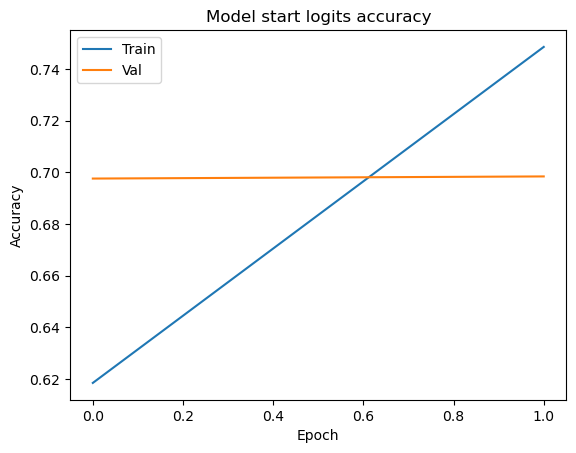

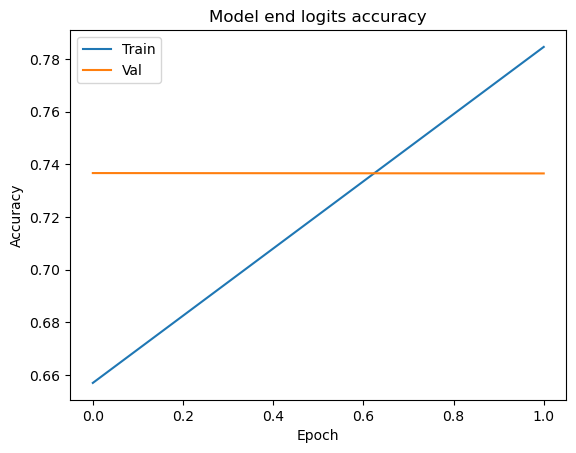

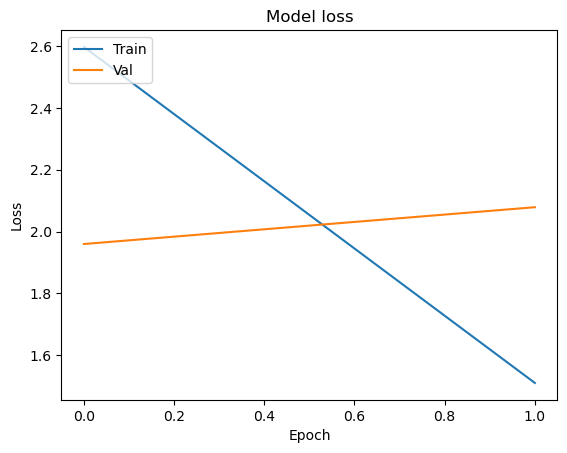

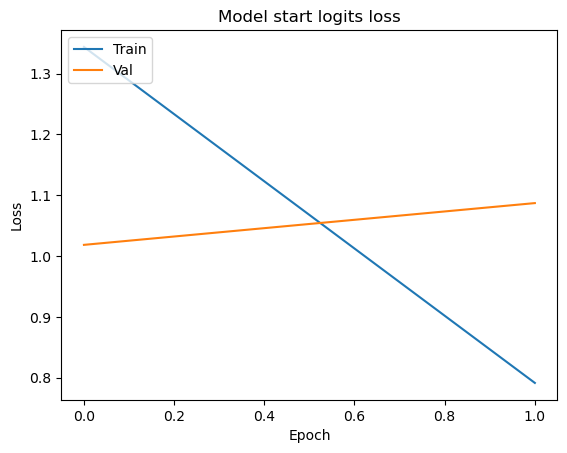

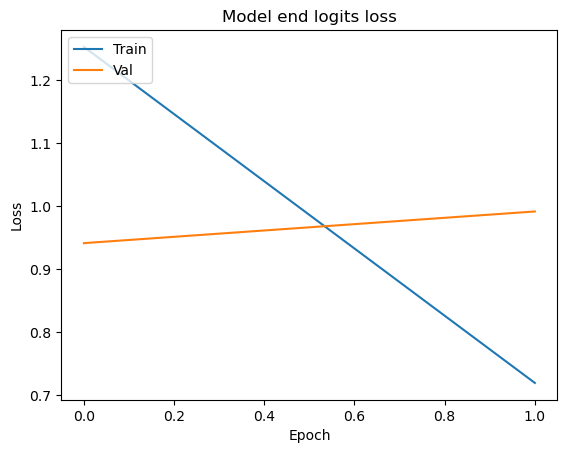

In [29]:
core_qa_utils.plot_and_save_fig_from_history(
    history,
    attributes=["start_logits_accuracy", "val_start_logits_accuracy"],
    title="Model start logits accuracy",
    y_label="Accuracy",
    x_label="Epoch",
    legend_descriptors=["Train", "Val"],
    figure_dir_path=figures_dir,
    figure_filename=f"{full_model_name}_start_accuracy.png",
)

core_qa_utils.plot_and_save_fig_from_history(
    history,
    attributes=["end_logits_accuracy", "val_end_logits_accuracy"],
    title="Model end logits accuracy",
    y_label="Accuracy",
    x_label="Epoch",
    legend_descriptors=["Train", "Val"],
    figure_dir_path=figures_dir,
    figure_filename=f"{full_model_name}_end_accuracy.png",
)

core_qa_utils.plot_and_save_fig_from_history(
    history,
    attributes=["loss", "val_loss"],
    title="Model loss",
    y_label="Loss",
    x_label="Epoch",
    legend_descriptors=["Train", "Val"],
    figure_dir_path=figures_dir,
    figure_filename=f"{full_model_name}_loss.png",
)

core_qa_utils.plot_and_save_fig_from_history(
    history,
    attributes=["start_logits_loss", "val_start_logits_loss"],
    title="Model start logits loss",
    y_label="Loss",
    x_label="Epoch",
    legend_descriptors=["Train", "Val"],
    figure_dir_path=figures_dir,
    figure_filename=f"{full_model_name}_start_loss.png",
)

core_qa_utils.plot_and_save_fig_from_history(
    history,
    attributes=["end_logits_loss", "val_end_logits_loss"],
    title="Model end logits loss",
    y_label="Loss",
    x_label="Epoch",
    legend_descriptors=["Train", "Val"],
    figure_dir_path=figures_dir,
    figure_filename=f"{full_model_name}_end_loss.png",
)

In [30]:
start_preds = extractive_qa_utils.get_class_preds(
    predictions=loaded_model_preds, output_key="start_logits"
)
end_preds = extractive_qa_utils.get_class_preds(
    predictions=loaded_model_preds, output_key="end_logits"
)

In [31]:
(
    start_precision,
    start_recall,
    start_f1,
) = extractive_qa_utils.get_classification_evaluation_metrics(
    class_actual=tokenized_test_dataset["start_positions"],
    class_preds=start_preds,
    average="micro",
)

print(f"Start positions precision score: ", start_precision)
print(f"Start positions recall score: ", start_recall)
print(f"Start positions F1 score: ", start_f1)

Start positions precision score:  0.6922072567344695
Start positions recall score:  0.6922072567344695
Start positions F1 score:  0.6922072567344695


In [32]:
(
    end_precision,
    end_recall,
    end_f1,
) = extractive_qa_utils.get_classification_evaluation_metrics(
    class_actual=tokenized_test_dataset["end_positions"],
    class_preds=end_preds,
    average="micro",
)

print(f"End positions precision score: ", end_precision)
print(f"End positions recall score: ", end_recall)
print(f"End positions F1 score: ", end_f1)

End positions precision score:  0.7330263881253436
End positions recall score:  0.7330263881253436
End positions F1 score:  0.7330263881253436


In [33]:
model_predicted_answers = tokenized_test_dataset.map(
    lambda row: extractive_qa_utils.extract_answer_tokens(row),
    remove_columns=[
        "input_ids",
        "token_type_ids",
        "attention_mask",
        "start_positions",
        "end_positions",
    ],
)

Map:   0%|          | 0/14552 [00:00<?, ? examples/s]

In [34]:
model_predicted_answers = model_predicted_answers.map(
    lambda row: {
        "answer_text": extractive_qa_utils.decode_answer_tokens(row, tokenizer)
    }
)

Map:   0%|          | 0/14552 [00:00<?, ? examples/s]

In [35]:
(
    exact_match_original,
    exact_match_lowercase,
    exact_match_lowercase_no_punctuation,
) = extractive_qa_utils.calculate_pure_exact_match(
    filtered_test_dataset, model_predicted_answers
)

print(f"Exact match for original dataset: ", exact_match_original["exact_match"])
print(f"Exact match case insensitive: ", exact_match_lowercase["exact_match"])
print(
    f"Exact match case insensitive and punctuation ignoring: ",
    exact_match_lowercase_no_punctuation["exact_match"],
)

Exact match for original dataset:  0.4169186366135239
Exact match case insensitive:  0.8523914238592634
Exact match case insensitive and punctuation ignoring:  0.8530786146234195


In [36]:
results = extractive_qa_utils.calculate_squad_exact_match(
    filtered_test_dataset, model_predicted_answers
)

print(f"SQuAD exact match: ", results["exact_match"])
print(f"SQuAD F1: ", results["f1"])

Flattening the indices:   0%|          | 0/14552 [00:00<?, ? examples/s]

SQuAD exact match:  88.3177570093458
SQuAD F1:  92.50495563005454
